### Importing Libraries

In [1]:
#!pip install nltk scikit-learn pandas
import nltk
nltk.download('reuters')
nltk.download('punkt')  # for tokenization
nltk.download('stopwords')  # optional
nltk.download('punkt')
nltk.download('punkt_tab')

import nltk
import pandas as pd
import re
from nltk.corpus import reuters
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler # Added StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             average_precision_score, classification_report,
                             roc_curve, precision_recall_curve, confusion_matrix)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
# Use PCA for visualization as UMAP might not be installed and TF-IDF is high-dim
from sklearn.decomposition import PCA
import seaborn as sns
import random
import time
import os
import warnings
from nltk.corpus import reuters
from nltk.corpus import stopwords
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)



# Get file IDs for training and test data
file_ids = reuters.fileids()

# Extract text and the first category as label (multi-label is also possible)
data = []
for file_id in file_ids:
    text = reuters.raw(file_id)
    categories = reuters.categories(file_id)
    if categories:  # some documents may not have a category
        data.append({
            "text": text,
            "label": categories[0]  # choose the first category (can be extended to multi-label)
        })

df = pd.DataFrame(data)



stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove numbers and punctuation
    text = re.sub(r"[^a-z\s]", "", text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and short tokens
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(tokens)


df["clean_text"] = df["text"].apply(clean_text)



[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:


# Check the number of documents available in the dataset
print("Total documents in Reuters-21578:", len(reuters.fileids()))

# Checking the categories available
print("Categories:", reuters.categories())

# Checking the number of documents in a particular category
print("Number of documents in 'trade' category:", len(reuters.fileids('trade')))

Total documents in Reuters-21578: 10788
Categories: ['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa', 'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn', 'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'dfl', 'dlr', 'dmk', 'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut', 'groundnut-oil', 'heat', 'hog', 'housing', 'income', 'instal-debt', 'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead', 'lei', 'lin-oil', 'livestock', 'lumber', 'meal-feed', 'money-fx', 'money-supply', 'naphtha', 'nat-gas', 'nickel', 'nkr', 'nzdlr', 'oat', 'oilseed', 'orange', 'palladium', 'palm-oil', 'palmkernel', 'pet-chem', 'platinum', 'potato', 'propane', 'rand', 'rape-oil', 'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'rye', 'ship', 'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean', 'strategic-metal', 'sugar', 'sun-meal', 'sun-oil', 'sunseed', 'tea', 'tin', 'trade', 'veg-oil', 'wheat', 'wpi', 'yen', 'zinc']
Number of documents in 'trade' categor

### Label Distribution

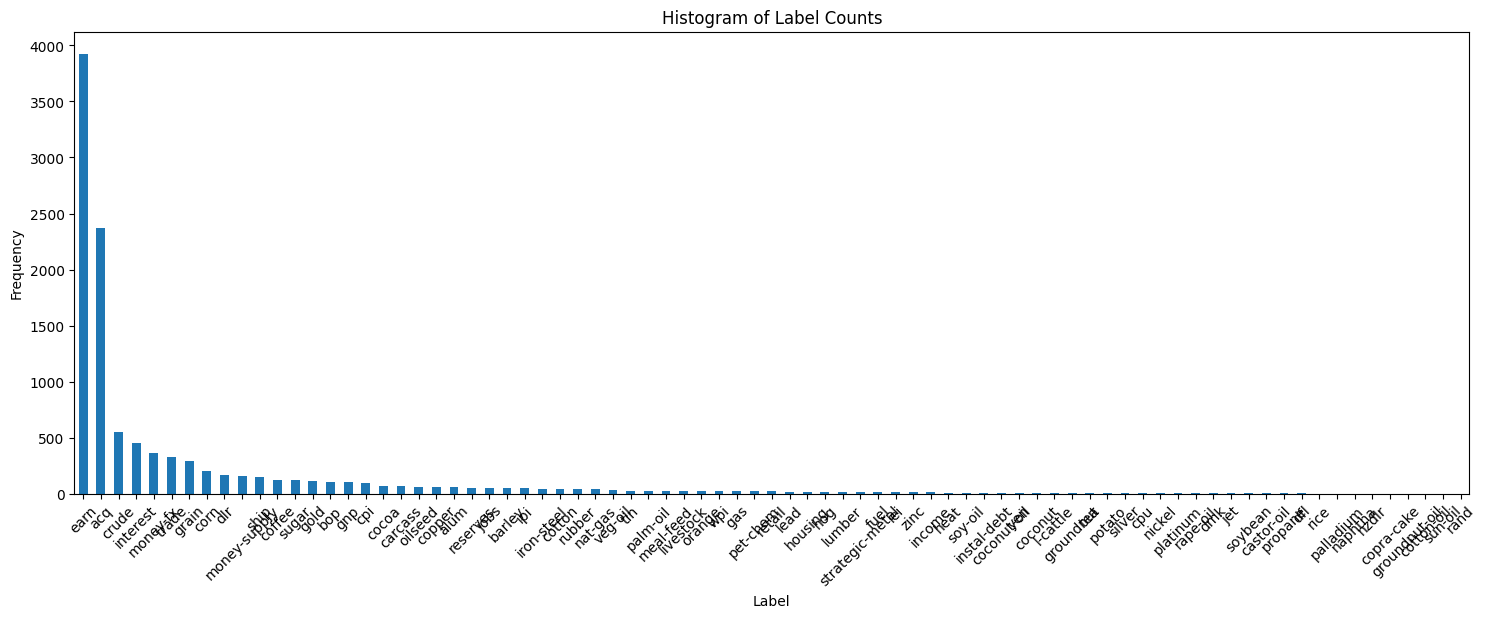

In [3]:


import matplotlib.pyplot as plt

# Assuming df is your pandas DataFrame
value_counts = df['label'].value_counts(normalize=False)

# Plotting the histogram
plt.figure(figsize=(18,6))
value_counts.plot(kind='bar')
plt.title('Histogram of Label Counts')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [4]:
df.head(3)

text  \
0  ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT\n  Mounting trade friction between the\n  U.S. And Japan has raised fears among many of Asia's exporting\n  nations that the row could inflict far-reaching economic\n  damage, businessmen and officials said.\n      They told Reuter correspondents in Asian capitals a U.S.\n  Move against Japan might boost protectionist sentiment in the\n  U.S. And lead to curbs on American imports of their products.\n      But some exporters said that while the conflict would hurt\n  them in the long-run, in the short-term Tokyo's loss might be\n  their gain.\n      The U.S. Has said it will impose 300 mln dlrs of tariffs on\n  imports of Japanese electronics goods on April 17, in\n  retaliation for Japan's alleged failure to stick to a pact not\n  to sell semiconductors on world markets at below cost.\n      Unofficial Japanese estimates put the impact of the tariffs\n  at 10 billion dlrs and spokesmen for major electronics firms\n  said they would virtually halt exports of products hit by the\n  new taxes.\n      "We wouldn't be able to do business," said a spokesman for\n  leading Japanese electronics firm Matsushita Electric\n  Industrial Co Ltd &lt;MC.T>.\n      "If the tariffs remain in place for any length of time\n  beyond a few months it will mean the complete erosion of\n  exports (of goods subject to tariffs) to the U.S.," said Tom\n  Murtha, a stock analyst at the Tokyo office of broker &lt;James\n  Capel and Co>.\n      In Taiwan, businessmen and officials are also worried.\n      "We are aware of the seriousness of the U.S. Threat against\n  Japan because it serves as a warning to us," said a senior\n  Taiwanese trade official who asked not to be named.\n      Taiwan had a trade trade surplus of 15.6 billion dlrs last\n  year, 95 pct of it with the U.S.\n      The surplus helped swell Taiwan's foreign exchange reserves\n  to 53 billion dlrs, among the world's largest.\n      "We must quickly open our markets, remove trade barriers and\n  cut import tariffs to allow imports of U.S. Products, if we\n  want to defuse problems from possible U.S. Retaliation," said\n  Paul Sheen, chairman of textile exporters &lt;Taiwan Safe Group>.\n      A senior official of South Korea's trade promotion\n  association said the trade dispute between the U.S. And Japan\n  might also lead to pressure on South Korea, whose chief exports\n  are similar to those of Japan.\n      Last year South Korea had a trade surplus of 7.1 billion\n  dlrs with the U.S., Up from 4.9 billion dlrs in 1985.\n      In Malaysia, trade officers and businessmen said tough\n  curbs against Japan might allow hard-hit producers of\n  semiconductors in third countries to expand their sales to the\n  U.S.\n      In Hong Kong, where newspapers have alleged Japan has been\n  selling below-cost semiconductors, some electronics\n  manufacturers share that view. But other businessmen said such\n  a short-term commercial advantage would be outweighed by\n  further U.S. Pressure to block imports.\n      "That is a very short-term view," said Lawrence Mills,\n  director-general of the Federation of Hong Kong Industry.\n      "If the whole purpose is to prevent imports, one day it will\n  be extended to other sources. Much more serious for Hong Kong\n  is the disadvantage of action restraining trade," he said.\n      The U.S. Last year was Hong Kong's biggest export market,\n  accounting for over 30 pct of domestically produced exports.\n      The Australian government is awaiting the outcome of trade\n  talks between the U.S. And Japan with interest and concern,\n  Industry Minister John Button said in Canberra last Friday.\n      "This kind of deterioration in trade relations between two\n  countries which are major trading partners of ours is a very\n  serious matter," Button said.\n      He said Australia's concerns centred on coal and beef,\n  Australia's two largest exports to Japan and also significant\n  U.S. Exports to th

In [5]:
df.shape

(10788, 3)

In [6]:


try:
    import umap
    use_umap = True
except ImportError:
    use_umap = False


# --- Suppress Warnings ---
warnings.filterwarnings("ignore", message=".*perplexity.*")
warnings.filterwarnings("ignore", message=".*Precision and F-score are ill-defined.*")
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.manifold._t_sne')
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in true_divide") # Ignore division by zero in metrics if classes are missing

# --- Configuration & Seed ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")



Using device: cuda


### Parameters & Hyperparameters Defination

In [109]:
# --- Parameters ---
# Reuters Data Parameters
NUM_KNOWN_CLASSES = 3      # Number of classes to treat as known
NUM_UNKNOWN_TRAIN_CLASSES = 5 # Number of unknown classes to include in training pool
# Remaining classes will be unknown test classes
MAX_TFIDF_FEATURES = 2000    # Max features for TF-IDF
UNKNOWN_LABEL_MAP = NUM_KNOWN_CLASSES # Label assigned to all unknown samples (e.g., 12)

# Model & Training Parameters (from example)
BATCH_SIZE = 128
LEARNING_RATE = 0.001
EPOCHS = 50 # Adjusted epochs based on text data convergence
EPOCHS_TUNE = 15 # Reduced epochs for faster hyperparameter tuning
FEATURE_DIM = 64
HIDDEN_DIM1 = 256
HIDDEN_DIM2 = 128

# Original Objectosphere parameters (from example)
LAMBDA_OBJ_ORIG = 0.05
XI_OBJ_ORIG = 30.0 # Adjusted default Xi based on feature dim potentially

# Hyperparameter Grid for Tuning Objectosphere (from example)
# PARAM_GRID = {
#     'lambda_obj': [0.05, 0.1,0.2,0.3, 0.5, 1.0],
#     'xi_obj': [0.05, 0.5, 1.0, 2,  5.0, 10.0, 20.0,30]

# }

PARAM_GRID = {
    # Lambda regularization parameter: typically controls the smoothness of the learned representations
    'lambda_obj': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0],

    # Xi regularization parameter: typically controls the scaling or trade-off between terms in the objective
    'xi_obj': [2.0, 5.0, 10.0, 15, 30]
}



### Data Preparation & Preprocessing

In [110]:
# --- NLTK Data Download ---

def download_nltk_data():
    nltk_packages = ['punkt', 'stopwords']
    for package in nltk_packages:
        try:
            nltk.data.find(f'corpora/{package}' if package != 'punkt' else f'tokenizers/{package}')
        except nltk.downloader.DownloadError:
            print(f"Downloading NLTK package: {package}")
            nltk.download(package, quiet=True)
download_nltk_data()

# --- 1. Data Loading and Preparation ---
# (load_and_prepare_reuters_for_example_format)
def load_and_prepare_reuters_for_example_format(num_known_classes, num_unknown_train, max_features, unknown_label_map, seed):
    print("\n--- Loading and Preparing Reuters Data (Example Format) ---")
    # Load data
    file_ids = reuters.fileids()
    data = []
    for file_id in file_ids:
        text = reuters.raw(file_id)
        categories = reuters.categories(file_id)
        if categories:
            data.append({"text": text, "label": categories[0], "id": file_id}) # Keep ID for split consistency
    df = pd.DataFrame(data)
    label_counts = df['label'].value_counts()
    labels_to_keep = label_counts[label_counts > 5].index
    df = df[df['label'].isin(labels_to_keep)].reset_index(drop=True)

    # Clean Text
    stop_words = set(stopwords.words('english'))
    def clean_text(text):
        text = text.lower(); text = re.sub(r"[^a-z\s]", "", text)
        tokens = word_tokenize(text); tokens = [w for w in tokens if w not in stop_words and len(w) > 2]
        return " ".join(tokens)
    df["clean_text"] = df["text"].apply(clean_text)

    # Select Known/Unknown Classes
    all_categories = df['label'].unique().tolist()
    n_classes_total = len(all_categories)
    if n_classes_total <= num_known_classes + num_unknown_train:
        raise ValueError("Not enough total categories for the desired known/unknown split.")

    rng = np.random.default_rng(seed)
    #known_categories = sorted(rng.choice(all_categories, size=num_known_classes, replace=False).tolist())
    known_categories = ['earn','acq','dlr']
    remaining_categories = sorted([c for c in all_categories if c not in known_categories])
    unknown_train_categories = sorted(rng.choice(remaining_categories, size=num_unknown_train, replace=False).tolist())
    unknown_test_categories = sorted([c for c in remaining_categories if c not in unknown_train_categories])
    num_unknown_test = len(unknown_test_categories)

    print(f"Total Categories: {n_classes_total}")
    print(f"Known Classes ({num_known_classes}): {known_categories[:]}...")
    print(f"Unknown Train Classes ({num_unknown_train}): {unknown_train_categories[:]}...")
    print(f"Unknown Test Classes ({num_unknown_test}): {unknown_test_categories[:]}...")
    print(f"Internal Label for All Unknowns: {unknown_label_map}")

    # Create Label Mapping (Known: 0 to N-1, Unknown: N)
    label_encoder = LabelEncoder()
    label_encoder.fit(known_categories) # Fit only on known categories for 0 to N-1 mapping
    known_class_names = label_encoder.classes_

    def get_mapped_label(label):
        if label in known_categories:
            return label_encoder.transform([label])[0]
        else:
            return unknown_label_map # Assign special label to all unknowns

    df['mapped_label'] = df['label'].apply(get_mapped_label)

    # Separate DataFrames based on original role
    df_known = df[df['label'].isin(known_categories)].copy()
    df_unknown_train = df[df['label'].isin(unknown_train_categories)].copy()
    df_unknown_test = df[df['label'].isin(unknown_test_categories)].copy()

    # --- Prepare Training/Validation Pool (Knowns + Training Unknowns) ---
    df_pool = pd.concat([df_known, df_unknown_train], ignore_index=True)

    # Split pool into Training and Validation sets based on document IDs
    pool_ids = df_pool['id'].unique()
    train_ids, val_ids = train_test_split(pool_ids, test_size=0.25, random_state=seed)

    df_train = df_pool[df_pool['id'].isin(train_ids)].copy()
    df_val = df_pool[df_pool['id'].isin(val_ids)].copy()

    # Check stratification manually (optional but informative)
    print("\nLabel distribution in Train/Val split:")
    print("Train:", df_train['mapped_label'].value_counts(normalize=True).sort_index())
    print("Val:", df_val['mapped_label'].value_counts(normalize=True).sort_index())
    if not (df_val['mapped_label'] == unknown_label_map).any():
         print(f"WARNING: Validation set contains NO unknown samples (label={unknown_label_map}). AUROC for tuning may be undefined.")


    # --- Prepare Final Test Set (Knowns from Val + Testing Unknowns) ---
    # We need some knowns in the test set. Take them from validation knowns.
    df_val_known = df_val[df_val['mapped_label'] < num_known_classes]
    num_unknown_test_samples = len(df_unknown_test)

    if len(df_val_known) > 0:
        # Try to balance known/unknown in test, or take min available
        num_known_test_samples = min(num_unknown_test_samples, len(df_val_known))
        # Ensure we don't sample more than available
        num_known_test_samples = max(0, min(num_known_test_samples, len(df_val_known)))
        if num_known_test_samples > 0:
           df_test_known = df_val_known.sample(n=num_known_test_samples, random_state=seed)
        else:
           df_test_known = pd.DataFrame(columns=df.columns) # Empty dataframe
    else:
        print("Warning: No known samples available in validation set to add to test set.")
        df_test_known = pd.DataFrame(columns=df.columns)

    # Combine known test samples and Unknown_test samples
    df_test = pd.concat([df_test_known, df_unknown_test], ignore_index=True)

    print(f"\nData Split Sizes:")
    print(f"  Train: {len(df_train)}")
    print(f"  Validation: {len(df_val)}")
    print(f"  Test: {len(df_test)} (Known: {len(df_test_known)}, Unknown: {len(df_unknown_test)})")
    print(f"Unique labels in y_train: {sorted(df_train['mapped_label'].unique())}")
    print(f"Unique labels in y_val: {sorted(df_val['mapped_label'].unique())}")
    print(f"Unique labels in y_test: {sorted(df_test['mapped_label'].unique())}")


    # --- TF-IDF Vectorization & Scaling ---
    print(f"\nFitting TF-IDF Vectorizer (max_features={max_features})...")
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
    X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['clean_text']).toarray()
    X_val_tfidf = tfidf_vectorizer.transform(df_val['clean_text']).toarray()
    # Handle empty test dataframe case
    if len(df_test)>0:
        X_test_tfidf = tfidf_vectorizer.transform(df_test['clean_text']).toarray()
    else:
        X_test_tfidf = np.empty((0, X_train_tfidf.shape[1]), dtype=float)

    input_dim = X_train_tfidf.shape[1]
    print(f"TF-IDF Feature dimension: {input_dim}")

    # Standard Scaling (often helpful for NNs)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_tfidf)
    X_val_scaled = scaler.transform(X_val_tfidf)
    X_test_scaled = scaler.transform(X_test_tfidf) if len(df_test)>0 else np.empty((0, input_dim), dtype=float)

    # --- Create DataLoaders ---
    y_train = df_train['mapped_label'].values
    y_val = df_val['mapped_label'].values
    y_test = df_test['mapped_label'].values if len(df_test)>0 else np.array([])

    train_dataset = TensorDataset(torch.FloatTensor(X_train_scaled), torch.LongTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_scaled), torch.LongTensor(y_val))
    # Handle empty test dataset case
    if len(X_test_scaled) > 0:
        test_dataset = TensorDataset(torch.FloatTensor(X_test_scaled), torch.LongTensor(y_test))
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    else:
        test_dataset = None
        test_loader = None


    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True) # Drop last helps with consistent batch sizes
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


    if not test_loader:
        print("\nWARNING: Test loader is empty. Final evaluation and plots cannot proceed.")

    return (train_loader, val_loader, test_loader, input_dim, scaler,
            known_categories, unknown_train_categories, unknown_test_categories)



### Model Architecture

In [111]:
# --- 2. Model Architecture ---

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, feature_dim, num_known_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.4) # From example
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4) # From example
        # Feature extraction layer
        self.feature_layer = nn.Linear(hidden_dim2, feature_dim)
        self.relu3 = nn.ReLU()
        # Final classification layer (Bias=False needed for provided EOS/Objecto loss assumptions)
        self.classifier = nn.Linear(feature_dim, num_known_classes, bias=False)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        features = self.relu3(self.feature_layer(x)) # f(x)
        logits = self.classifier(features) # Logits for known classes
        return logits, features



### Defining Loss

In [112]:
# --- 3. Loss Function Implementation ---
# (EntropicOpenSetLoss and ObjectosphereLoss classes)
class EntropicOpenSetLoss(nn.Module):
    def __init__(self, num_known_classes):
        super(EntropicOpenSetLoss, self).__init__()
        self.num_known_classes = num_known_classes
        self.cross_entropy = nn.CrossEntropyLoss(reduction='none') # Use 'none' for manual averaging

    def forward(self, logits, labels):
        known_mask = labels < self.num_known_classes
        unknown_mask = labels == self.num_known_classes # Assumes unknown label is num_known_classes

        loss_known = torch.tensor(0.0, device=logits.device)
        loss_unknown = torch.tensor(0.0, device=logits.device)
        count_known = known_mask.sum()
        count_unknown = unknown_mask.sum()

        if count_known > 0:
            loss_known = self.cross_entropy(logits[known_mask], labels[known_mask]).sum()

        if count_unknown > 0:
            logits_unknown = logits[unknown_mask]
            # Maximize entropy for unknowns == minimize average negative log probability
            log_probs_unknown = torch.log_softmax(logits_unknown, dim=1)
            loss_unknown = -log_probs_unknown.mean(dim=1).sum() # Maximize entropy by minimizing this

        # Average over the entire batch size
        batch_size = len(labels)
        if batch_size > 0:
            total_loss = (loss_known + loss_unknown) / batch_size
        else:
            total_loss = torch.tensor(0.0, device=logits.device)

        return total_loss

class ObjectosphereLoss(nn.Module):
    def __init__(self, num_known_classes, lambda_obj, xi_obj):
        super(ObjectosphereLoss, self).__init__()
        self.num_known_classes = num_known_classes
        self.lambda_obj = lambda_obj
        self.xi_obj = xi_obj
        # This loss *builds upon* the Entropic Open Set loss from the example code
        self.entropic_loss = EntropicOpenSetLoss(num_known_classes)
        self.epsilon = 1e-6 # For numerical stability

    def forward(self, logits, features, labels):
      je_loss = self.entropic_loss(logits, labels)

      known_mask = labels != self.num_known_classes
      unknown_mask = labels == self.num_known_classes

      jr_penalty = torch.tensor(0.0, device=logits.device)

      # Penalty for known samples: max(0, xi - ||F(x)||)^2
      if known_mask.sum() > 0:
          features_known = features[known_mask]
          mag_known = torch.norm(features_known, p=2, dim=1)
          penalty_known = torch.clamp(self.xi_obj - mag_known, min=0) ** 2
          jr_penalty += self.lambda_obj * penalty_known.mean()

      # Penalty for unknown samples: ||F(x)||^2
      if unknown_mask.sum() > 0:
          features_unknown = features[unknown_mask]
          mag_unknown = torch.norm(features_unknown, p=2, dim=1)
          penalty_unknown = mag_unknown ** 2
          jr_penalty += self.lambda_obj * penalty_unknown.mean()

      total_loss = je_loss + jr_penalty
      return total_loss







### Training Loop

In [113]:
# --- 4. Training Loop ---

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device, loss_type='baseline', model_label="Model", verbose=True, num_known_classes=NUM_KNOWN_CLASSES):
    model.to(device)
    best_val_loss = float('inf')
    best_model_state = None # Store best model state based on validation loss
    if verbose:
        print(f"\n--- Training Model ({model_label} - {loss_type.upper()}) ---")

    for epoch in range(epochs):
        model.train()
        train_loss_epoch = 0.0
        correct_train_known = 0
        total_train_known = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            logits, features = model(inputs)

            # --- Loss Calculation (Matches Example Logic) ---
            known_mask_batch = labels < num_known_classes
            if loss_type == 'baseline':
                # Baseline trains ONLY on known data points, ignore unknowns in batch
                if not known_mask_batch.any(): continue # Skip if batch has no knowns
                loss = criterion(logits[known_mask_batch], labels[known_mask_batch])
            elif loss_type == 'eos':
                # EOS uses all data (knowns for CE, unknowns for entropy)
                loss = criterion(logits, labels)
            elif loss_type == 'objectosphere':
                 # Objectosphere uses all data (knowns for CE, unknowns for entropy + radius penalty)
                loss = criterion(logits, features, labels)
            else:
                 raise ValueError("Unknown loss_type")

            # Prevent loss calculation if loss is NaN or Inf
            if torch.isnan(loss) or torch.isinf(loss):
                 print(f"Warning: NaN/Inf loss detected at epoch {epoch+1} for {model_label}. Skipping batch.")
                 continue # Skip backward pass and optimizer step for this batch

            loss.backward()
            # Gradient clipping (optional, but can help stability)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss_epoch += loss.item() * inputs.size(0) # Accumulate loss scaled by batch size

            # --- Training Accuracy (on knowns only within the batch) ---
            if known_mask_batch.any():
                _, predicted = torch.max(logits[known_mask_batch].data, 1)
                total_train_known += labels[known_mask_batch].size(0)
                correct_train_known += (predicted == labels[known_mask_batch]).sum().item()


        # Calculate average loss for the epoch
        num_samples_processed = len(train_loader.sampler) if hasattr(train_loader, 'sampler') and train_loader.drop_last else len(train_loader.dataset) # Robust way
        if num_samples_processed > 0:
             train_loss_epoch /= num_samples_processed
        else:
             train_loss_epoch = 0

        train_acc_known = 100. * correct_train_known / total_train_known if total_train_known > 0 else 0

        # --- Validation ---
        model.eval()
        val_loss_epoch = 0.0
        correct_val_known = 0
        total_val_known = 0
        if val_loader is not None and len(val_loader.dataset) > 0:
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logits, features = model(inputs)

                    known_mask_batch = labels < num_known_classes

                    # --- Validation Loss (use same logic as training for comparability) ---
                    if loss_type == 'baseline':
                        if not known_mask_batch.any(): continue
                        # Use the main criterion directly (e.g., CrossEntropyLoss)
                        loss = criterion(logits[known_mask_batch], labels[known_mask_batch])
                    elif loss_type == 'eos':
                        loss = criterion(logits, labels)
                    elif loss_type == 'objectosphere':
                        loss = criterion(logits, features, labels)

                    if not (torch.isnan(loss) or torch.isinf(loss)): # Check loss before accumulating
                       val_loss_epoch += loss.item() * inputs.size(0)

                    # --- Validation Accuracy (on knowns only) ---
                    if known_mask_batch.any():
                        _, predicted = torch.max(logits[known_mask_batch].data, 1)
                        total_val_known += labels[known_mask_batch].size(0)
                        correct_val_known += (predicted == labels[known_mask_batch]).sum().item()

            if len(val_loader.dataset)>0:
                val_loss_epoch /= len(val_loader.dataset)
            else:
                val_loss_epoch = float('inf') # Set high if no val data

            val_acc_known = 100. * correct_val_known / total_val_known if total_val_known > 0 else 0

            if verbose and ((epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs -1) : # Reduced print frequency
                 print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss_epoch:.4f} | Tr Acc(K): {train_acc_known:.2f}% | Val Loss: {val_loss_epoch:.4f} | Val Acc(K): {val_acc_known:.2f}%")

            # Save best model based on validation loss
            if val_loss_epoch < best_val_loss:
                best_val_loss = val_loss_epoch
                best_model_state = model.state_dict()
                # Optional: Save checkpoint to file
                # torch.save(model.state_dict(), f'best_model_{model_label}_{loss_type}.pth')
        else: # No validation loader
             if verbose and ((epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs -1) :
                 print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss_epoch:.4f} | Train Acc (K): {train_acc_known:.2f}% | Val Loss: N/A | Val Acc (K): N/A")
             # If no validation, save the last epoch as 'best'
             best_model_state = model.state_dict()


    if verbose:
        print(f"Training finished for {model_label}.")

    # Load the best model state found during validation (or last state if no validation)
    if best_model_state:
        print(f"Loading best model state for {model_label} (Val Loss: {best_val_loss:.4f})")
        model.load_state_dict(best_model_state)
    else:
        print(f"Warning: No best model state found for {model_label}. Using final epoch model.")

    return model # Return trained model (best state loaded if possible)



### Evaluation

In [114]:
# --- 5. Evaluation ---

def evaluate_openset(model, test_loader, device, num_known_classes, unknown_label, model_label="Model"):
    # Check if test_loader is valid
    if not test_loader:
        print(f"Evaluation skipped for {model_label}: Test loader is empty.")
        # Return a dictionary with default/empty values matching expected structure
        return {
            "known_accuracy": 0.0, "auroc": 0.5, "f1_unknown": 0.0, # Default AUROC to 0.5
            "classification_report_openset": "N/A - No test data",
            "labels": np.array([]), "preds_class": np.array([]),
            "msp": np.array([]), "features": np.array([]),
            "logits": np.array([]), "openset_true": np.array([]),
            "openset_pred": np.array([]), "openset_scores": np.array([])
        }

    print(f"\n--- Evaluating {model_label} ---")
    model.eval()
    all_labels = []
    all_preds_class = [] # Predicted known class index (0 to N-1)
    all_msp = [] # Maximum Softmax Probability
    all_features = []
    all_logits = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            logits, features = model(inputs)

            # Softmax is applied across the known class logits
            softmax_scores = torch.softmax(logits, dim=1)
            msp, predicted_class = torch.max(softmax_scores, dim=1)

            all_labels.extend(labels.numpy())
            all_preds_class.extend(predicted_class.cpu().numpy())
            all_msp.extend(msp.cpu().numpy())
            all_features.extend(features.cpu().numpy())
            all_logits.extend(logits.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds_class = np.array(all_preds_class)
    all_msp = np.array(all_msp)
    all_features = np.array(all_features)
    all_logits = np.array(all_logits)

    # Separate known and unknown samples from the test set based on mapped label
    known_mask_test = all_labels < num_known_classes
    unknown_mask_test = all_labels == unknown_label # Unknowns have the specific label

    results = {
        "known_accuracy": 0.0, "auroc": 0.5, "f1_unknown": 0.0, # Default AUROC to 0.5
        "classification_report_openset": "N/A", "labels": all_labels,
        "preds_class": all_preds_class, "msp": all_msp, "features": all_features,
        "logits": all_logits, "openset_true": np.array([]),
        "openset_pred": np.array([]), "openset_scores": np.array([])
    }

    # --- Overall Accuracy on Known Classes ---
    if known_mask_test.any():
        known_labels_true = all_labels[known_mask_test]
        known_labels_pred = all_preds_class[known_mask_test]
        results["known_accuracy"] = accuracy_score(known_labels_true, known_labels_pred)
        print(f"\n--- {model_label}: Classification Report (Known Classes Only) ---")
        # Ensure labels for report are within the range present
        present_labels = np.unique(np.concatenate((known_labels_true, known_labels_pred)))
        target_labels = np.arange(num_known_classes)
        report_labels = [l for l in target_labels if l in present_labels]
        if not report_labels:
             print("No known class predictions/labels found for report.")
        else:
             print(classification_report(known_labels_true, known_labels_pred, labels=report_labels, target_names=[f'Known_{i}' for i in report_labels], zero_division=0))
    else:
        print(f"Warning ({model_label}): No known samples in the test set for accuracy calculation.")

    # --- Open-Set Evaluation (Known vs. Unknown detection) ---
    # True label: 1 if unknown (label == unknown_label), 0 if known (label < num_known_classes)
    # Score: Use 1 - MSP. Higher score means more likely UNKNOWN.
    if unknown_mask_test.any() and known_mask_test.any():
        openset_true_labels = np.where(unknown_mask_test, 1, 0) # 1 = Unknown, 0 = Known
        # Use 1 - MSP as the score, where high score indicates potential unknown
        openset_scores = 1.0 - all_msp
        results["openset_true"] = openset_true_labels
        results["openset_scores"] = openset_scores

        # Calculate AUROC
        try:
            # Ensure both classes (0 and 1) are present for AUROC calculation
            if len(np.unique(openset_true_labels)) > 1:
                 auroc = roc_auc_score(openset_true_labels, openset_scores)
                 results["auroc"] = auroc
            else:
                 print(f"Warning ({model_label}): Only one class ({np.unique(openset_true_labels)[0]}) present in open-set true labels. AUROC is not defined (setting to 0.5).")
                 # results["auroc"] remains default 0.5
        except ValueError as e:
            print(f"Warning ({model_label}): Could not calculate AUROC. Error: {e}. Setting to 0.5.")
            # results["auroc"] remains default 0.5

        # Determine threshold based on percentile of scores for KNOWN samples (openset_true_labels == 0)
        known_scores = openset_scores[openset_true_labels == 0]
        if len(known_scores) > 0:
            # A high score (1-MSP) means unknown. Find threshold keeping 95% knowns (low scores) below it.
            threshold = np.percentile(known_scores, 95)
        else: # No known samples to base threshold on, use median of all scores
             threshold = np.median(openset_scores) if len(openset_scores) > 0 else 0.5 # Fallback threshold
        print(f"{model_label} Open-Set Threshold (based on 1-MSP, aiming to keep 95% knowns): {threshold:.4f}")

        # Predict: 1 (Unknown) if score > threshold, 0 (Known) otherwise
        openset_pred_labels = (openset_scores > threshold).astype(int)
        results["openset_pred"] = openset_pred_labels

        print(f"\n--- {model_label}: Open-Set Classification Report (0=Known, 1=Unknown) ---")
        # Ensure both labels 0 and 1 are specified for the report
        report_str = classification_report(openset_true_labels, openset_pred_labels, labels=[0, 1], target_names=['Known', 'Unknown'], zero_division=0)
        print(report_str)
        results["classification_report_openset"] = report_str

        # Extract F1 score for the 'Unknown' class (label 1)
        try:
            report_dict = classification_report(openset_true_labels, openset_pred_labels, labels=[0, 1], target_names=['Known', 'Unknown'], output_dict=True, zero_division=0)
            if 'Unknown' in report_dict:
                 results["f1_unknown"] = report_dict['Unknown']['f1-score']
            else:
                 print(f"Warning ({model_label}): 'Unknown' class metrics not found in open-set classification report dictionary.")
                 results["f1_unknown"] = 0.0 # Set F1 to 0 if class not found
        except Exception as e:
            print(f"Warning ({model_label}): Could not extract F1 score. Error: {e}")
            results["f1_unknown"] = 0.0 # Set F1 to 0 on error


    elif not unknown_mask_test.any():
         print(f"Warning ({model_label}): No unknown samples (label={unknown_label}) in the test set for open-set evaluation.")
    elif not known_mask_test.any():
         print(f"Warning ({model_label}): No known samples (label < {num_known_classes}) in the test set for open-set evaluation.")

    print(f"\n{model_label} - Final Summary:")
    print(f"  Known Accuracy: {results.get('known_accuracy', 0.0):.4f}") # Use .get for safety
    print(f"  AUROC (Known vs Unknown): {results.get('auroc', 0.5):.4f}")
    print(f"  F1 Score (Unknown Class Detection): {results.get('f1_unknown', 0.0):.4f}")
    return results




### Validation Performance Helper Func

In [115]:
# --- Validation Performance Helper ---

def get_validation_performance(model, val_loader, device, num_known_classes, unknown_label):
    """Evaluates the model on the validation set and returns AUROC for tuning."""
    model.eval()
    all_labels = []
    all_msp = []

    if not val_loader or len(val_loader.dataset) == 0:
         print("Warning (get_validation_performance): Validation loader is empty.")
         return {"val_auroc": 0.5} # Return default neutral AUROC

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            logits, _ = model(inputs) # Don't need features for simple AUROC eval based on MSP
            softmax_scores = torch.softmax(logits, dim=1)
            msp, _ = torch.max(softmax_scores, dim=1)

            all_labels.extend(labels.numpy())
            all_msp.extend(msp.cpu().numpy())

    all_labels = np.array(all_labels)
    all_msp = np.array(all_msp)

    known_mask_val = all_labels < num_known_classes
    unknown_mask_val = all_labels == unknown_label

    val_auroc = 0.5 # Default if cannot compute

    # Calculate AUROC: 1 = Unknown, 0 = Known; Score = 1 - MSP
    if unknown_mask_val.any() and known_mask_val.any():
        openset_true_labels_val = np.where(unknown_mask_val, 1, 0)
        openset_scores_val = 1.0 - all_msp
        try:
            # Check if both classes are present
            if len(np.unique(openset_true_labels_val)) > 1:
                val_auroc = roc_auc_score(openset_true_labels_val, openset_scores_val)
            # else: AUROC remains 0.5 if only one class present
        except ValueError:
            pass # Keep default val_auroc = 0.5 if error
    # else: AUROC remains 0.5 if only knowns or only unknowns are in val set

    return {"val_auroc": val_auroc}



### Visulization Utils

In [116]:
# --- 6. Visualization ---

def plot_umap_features(features, labels, num_known_classes, unknown_label, title, ax):
    """ Plots UMAP of features, requires labels with unknown_label """
    print(f"\nGenerating UMAP plot: {title}")
    if not use_umap:
        print("UMAP not installed, skipping UMAP plot.")
        ax.text(0.5, 0.5, 'UMAP not installed', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(f'{title} - UMAP (Skipped)')
        return

    if features is None or features.shape[0] < 2:
        print("Skipping UMAP plot: Not enough features.")
        ax.text(0.5, 0.5, 'Not enough features for UMAP', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(f'{title} - UMAP')
        return

    try:
        # Handle potential NaN/Inf in features before reduction
        if np.any(np.isnan(features)) or np.any(np.isinf(features)):
            print(f"Warning: NaN/Inf found in features for {title}. Replacing with 0 for UMAP.")
            features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)

        # UMAP parameters (can be tuned)
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=SEED, metric='euclidean')
        embedding = reducer.fit_transform(features)

    except Exception as e:
        print(f"Error during UMAP fitting for {title}: {e}. Skipping plot.")
        ax.text(0.5, 0.5, f'UMAP Failed:\n{e}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(f'{title} - UMAP')
        return

    df_plot = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
    df_plot['Mapped Label'] = labels
    # Create a meaningful label string
    label_map_plot = {i: f'Known {i}' for i in range(num_known_classes)}
    label_map_plot[unknown_label] = 'Unknown'
    df_plot['Class Label'] = df_plot['Mapped Label'].map(label_map_plot).fillna('Other')

    unique_labels_plot = sorted(df_plot['Class Label'].unique())
    palette = {}
    # Use a distinct color palette for known classes, and red for unknown
    known_colors = sns.color_palette("viridis", n_colors=num_known_classes)
    color_idx = 0
    for lbl in unique_labels_plot:
        if 'Unknown' in lbl:
            palette[lbl] = 'red'
        else:
            try: # Map known classes consistently
                known_idx = int(lbl.split()[-1])
                palette[lbl] = known_colors[known_idx % len(known_colors)]
            except: # Fallback
                 palette[lbl] = known_colors[color_idx % len(known_colors)]
                 color_idx +=1

    sns.scatterplot(
        x="UMAP1", y="UMAP2", hue="Class Label", hue_order=unique_labels_plot, palette=palette,
        style="Class Label", markers={lbl: ('o' if 'Known' in lbl else 'X') for lbl in unique_labels_plot},
        s=30, data=df_plot, legend=False, # Keep legend off for clarity
        alpha=0.7, ax=ax
    )
    ax.set_title(f'{title} - UMAP')
    ax.set_xlabel("UMAP Dimension 1")
    ax.set_ylabel("UMAP Dimension 2")

# (Plotting functions: plot_pca_features, plot_msp_histogram, plot_feature_magnitude_histogram remain the same)
def plot_pca_features(features, labels, num_known_classes, unknown_label, title, ax):
    """ Plots PCA of features, requires labels with unknown_label """
    print(f"\nGenerating PCA plot: {title}")
    if features is None or features.shape[0] < 2:
        print("Skipping PCA plot: Not enough features.")
        ax.text(0.5, 0.5, 'Not enough features for PCA', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(f'{title} - PCA')
        return

    pca = PCA(n_components=2, random_state=SEED)
    try:
        # Handle potential NaN/Inf in features before PCA
        if np.any(np.isnan(features)) or np.any(np.isinf(features)):
            print(f"Warning: NaN/Inf found in features for {title}. Replacing with 0 for PCA.")
            features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
        pca_results = pca.fit_transform(features)
    except Exception as e:
        print(f"Error during PCA fitting for {title}: {e}. Skipping plot.")
        ax.text(0.5, 0.5, f'PCA Failed:\n{e}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(f'{title} - PCA')
        return

    df_pca = pd.DataFrame(pca_results, columns=['PC1', 'PC2'])
    df_pca['Mapped Label'] = labels
    # Create a meaningful label string
    label_map_plot = {i: f'Known {i}' for i in range(num_known_classes)}
    label_map_plot[unknown_label] = 'Unknown'
    df_pca['Class Label'] = df_pca['Mapped Label'].map(label_map_plot).fillna('Other') # Should not be 'Other'


    unique_labels_plot = sorted(df_pca['Class Label'].unique())
    palette = {}
    # Use a distinct color palette for known classes, and red for unknown
    known_colors = sns.color_palette("viridis", n_colors=num_known_classes)
    color_idx = 0
    for lbl in unique_labels_plot:
        if 'Unknown' in lbl:
            palette[lbl] = 'red'
        else:
            # Extract class index to map consistently
            try:
                known_idx = int(lbl.split()[-1])
                palette[lbl] = known_colors[known_idx % len(known_colors)]
            except: # Fallback if label format unexpected
                 palette[lbl] = known_colors[color_idx % len(known_colors)]
                 color_idx +=1


    sns.scatterplot(
        x="PC1", y="PC2", hue="Class Label", hue_order=unique_labels_plot, palette=palette,
        style="Class Label", markers={lbl: ('o' if 'Known' in lbl else 'X') for lbl in unique_labels_plot},
        s=30, data=df_pca, legend=False, # Turn off default legend for clarity with many classes
        alpha=0.7, ax=ax
    )
    ax.set_title(f'{title} - PCA')
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    # Optional: Add simplified legend manually if needed
    # handles = [plt.Line2D([0], [0], marker='o', color='w', label='Known', markerfacecolor='blue', markersize=8),
    #            plt.Line2D([0], [0], marker='X', color='w', label='Unknown', markerfacecolor='red', markersize=8)]
    # ax.legend(handles=handles, title="Class Type", fontsize=8)


def plot_msp_histogram(msp_scores, labels, num_known_classes, unknown_label, title, ax):
    print(f"Generating MSP Histogram: {title}")
    if msp_scores is None or len(msp_scores) == 0:
         print("Skipping MSP Histogram: No scores.")
         ax.text(0.5, 0.5, 'No scores for MSP Histogram', ha='center', va='center', transform=ax.transAxes)
         ax.set_title(f'{title} - MSP')
         return

    known_mask = labels < num_known_classes
    unknown_mask = labels == unknown_label
    msp_known = msp_scores[known_mask]
    msp_unknown = msp_scores[unknown_mask]

    if len(msp_known) > 0:
         sns.histplot(msp_known, bins=30, color='blue', label=f'Known (N={len(msp_known)})', kde=True, stat='density', alpha=0.6, ax=ax)
    if len(msp_unknown) > 0:
        sns.histplot(msp_unknown, bins=30, color='red', label=f'Unknown (N={len(msp_unknown)})', kde=True, stat='density', alpha=0.6, ax=ax)

    ax.set_title(f'{title} - MSP')
    ax.set_xlabel('Max Softmax Probability (MSP)')
    ax.set_ylabel('Density')
    ax.set_xlim(0, 1.05)
    if len(msp_known) > 0 or len(msp_unknown) > 0: ax.legend(fontsize=8)


def plot_feature_magnitude_histogram(features, labels, num_known_classes, unknown_label, title, ax, xi_obj=None):
    print(f"Generating Feature Magnitude Histogram: {title}")
    if features is None or features.shape[0] == 0:
        print("Skipping Feature Magnitude Histogram: No features.")
        ax.text(0.5, 0.5, 'No features for Mag Histogram', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{title} - Feat Mag')
        return
    # Handle potential NaN/Inf in features before norm
    if np.any(np.isnan(features)) or np.any(np.isinf(features)):
        print(f"Warning: NaN/Inf found in features for {title}. Replacing with 0 before norm.")
        features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)


    known_mask = labels < num_known_classes
    unknown_mask = labels == unknown_label
    magnitudes = np.linalg.norm(features, axis=1)
    mags_known = magnitudes[known_mask]
    mags_unknown = magnitudes[unknown_mask]

    if len(mags_known) > 0:
        sns.histplot(mags_known, bins=30, color='blue', label=f'Known (N={len(mags_known)})', kde=True, stat='density', alpha=0.6, ax=ax)
    if len(mags_unknown) > 0:
        sns.histplot(mags_unknown, bins=30, color='red', label=f'Unknown (N={len(mags_unknown)})', kde=True, stat='density', alpha=0.6, ax=ax)

    # Add line for Objectosphere margin if provided (relevant for Objectosphere model plots)
    if xi_obj is not None:
        ax.axvline(xi_obj, color='green', linestyle='--', label=f'Obj Margin (ξ={xi_obj:.1f})')

    ax.set_title(f'{title} - Feat Mag')
    ax.set_xlabel('Feature Magnitude ||f(x)||₂')
    ax.set_ylabel('Density')
    # Adjust xlim based on data?
    if len(magnitudes)>0:
        upper_lim = max(np.percentile(magnitudes, 99.5) if len(magnitudes) > 0 else 10, (xi_obj or 0)+5) # Dynamic xlim + margin
        ax.set_xlim(0, upper_lim)
    if len(mags_known) > 0 or len(mags_unknown) > 0 or xi_obj is not None: ax.legend(fontsize=8)




In [117]:
def plot_msp_histogram(msp_scores, labels, num_known_classes, unknown_label, title, ax):
    print(f"Generating MSP KDE Plot: {title}")
    if msp_scores is None or len(msp_scores) == 0:
        print("Skipping MSP KDE Plot: No scores.")
        ax.text(0.5, 0.5, 'No scores for MSP KDE Plot', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{title} - MSP')
        return

    known_mask = labels < num_known_classes
    unknown_mask = labels == unknown_label
    msp_known = msp_scores[known_mask]
    msp_unknown = msp_scores[unknown_mask]

    if len(msp_known) > 0:
        sns.kdeplot(msp_known, color='blue', label=f'Known (N={len(msp_known)})', shade=True, alpha=0.6, ax=ax)
    if len(msp_unknown) > 0:
        sns.kdeplot(msp_unknown, color='red', label=f'Unknown (N={len(msp_unknown)})', shade=True, alpha=0.6, ax=ax)

    ax.set_title(f'{title} - MSP')
    ax.set_xlabel('Max Softmax Probability (MSP)')
    ax.set_ylabel('Density')
    ax.set_xlim(0, 1.05)
    if len(msp_known) > 0 or len(msp_unknown) > 0: ax.legend(fontsize=8)


def plot_feature_magnitude_histogram(features, labels, num_known_classes, unknown_label, title, ax, xi_obj=None):
    print(f"Generating Feature Magnitude KDE Plot: {title}")
    if features is None or features.shape[0] == 0:
        print("Skipping Feature Magnitude KDE Plot: No features.")
        ax.text(0.5, 0.5, 'No features for Mag KDE Plot', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{title} - Feat Mag')
        return

    # Handle potential NaN/Inf in features before norm
    if np.any(np.isnan(features)) or np.any(np.isinf(features)):
        print(f"Warning: NaN/Inf found in features for {title}. Replacing with 0 before norm.")
        features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)

    known_mask = labels < num_known_classes
    unknown_mask = labels == unknown_label
    magnitudes = np.linalg.norm(features, axis=1)
    mags_known = magnitudes[known_mask]
    mags_unknown = magnitudes[unknown_mask]

    if len(mags_known) > 0:
        sns.kdeplot(mags_known, color='blue', label=f'Known (N={len(mags_known)})', shade=True, alpha=0.6, ax=ax)
    if len(mags_unknown) > 0:
        sns.kdeplot(mags_unknown, color='red', label=f'Unknown (N={len(mags_unknown)})', shade=True, alpha=0.6, ax=ax)

    # Add line for Objectosphere margin if provided (relevant for Objectosphere model plots)
    if xi_obj is not None:
        ax.axvline(xi_obj, color='green', linestyle='--', label=f'Obj Margin (ξ={xi_obj:.1f})')

    ax.set_title(f'{title} - Feat Mag')
    ax.set_xlabel('Feature Magnitude ||f(x)||₂')
    ax.set_ylabel('Density')

    # Adjust xlim based on data?
    if len(magnitudes) > 0:
        upper_lim = max(np.percentile(magnitudes, 99.5) if len(magnitudes) > 0 else 10, (xi_obj or 0) + 5)  # Dynamic xlim + margin
        ax.set_xlim(0, upper_lim)
    if len(mags_known) > 0 or len(mags_unknown) > 0 or xi_obj is not None:
        ax.legend(fontsize=8)


In [118]:
# --- 7. Hyperparameter Tuning Function ---

def tune_objectosphere_hyperparameters(param_grid, input_dim, train_loader, val_loader, device, num_known_classes, unknown_label, epochs_tune):
    print("\n" + "="*30 + " OBJECTOSPHERE HYPERPARAMETER TUNING " + "="*30)
    best_val_auroc = -1.0 # Init below 0.5
    best_params = {'lambda_obj': None, 'xi_obj': None}
    tuning_results = []

    total_combinations = len(param_grid['lambda_obj']) * len(param_grid['xi_obj'])
    current_combination = 0
    start_time = time.time()

    # Ensure validation loader exists and has data
    if not val_loader or len(val_loader.dataset) == 0:
        print("Validation loader empty. Skipping hyperparameter tuning.")
        # Fallback to original parameters if tuning cannot be performed
        best_params['lambda_obj'] = LAMBDA_OBJ_ORIG
        best_params['xi_obj'] = XI_OBJ_ORIG
        return best_params

    for lambda_val in param_grid['lambda_obj']:
        for xi_val in param_grid['xi_obj']:
            current_combination += 1
            print(f"\n[Tuning {current_combination}/{total_combinations}] Testing: lambda={lambda_val}, xi={xi_val}")

            # --- Train a temporary model ---
            # Use the standard MLP architecture defined earlier
            tune_model = MLP(input_dim, HIDDEN_DIM1, HIDDEN_DIM2, FEATURE_DIM, num_known_classes).to(device)
            tune_optimizer = optim.Adam(tune_model.parameters(), lr=LEARNING_RATE)
            # Use the ObjectosphereLoss class defined earlier
            tune_criterion = ObjectosphereLoss(num_known_classes, lambda_val, xi_val)

            # Train for fewer epochs
            tune_model = train_model(tune_model, train_loader, val_loader, tune_criterion, tune_optimizer,
                                     epochs=epochs_tune, device=device, loss_type='objectosphere',
                                     model_label=f"Tune(l={lambda_val},x={xi_val})", verbose=False, # Less verbose during tuning
                                     num_known_classes=num_known_classes)

            # --- Evaluate on Validation Set using AUROC ---
            val_perf = get_validation_performance(tune_model, val_loader, device, num_known_classes, unknown_label)
            val_auroc = val_perf["val_auroc"]
            tuning_results.append({'lambda': lambda_val, 'xi': xi_val, 'val_auroc': val_auroc})
            print(f"  -> Validation AUROC: {val_auroc:.4f}")

            # --- Update Best Parameters ---
            # We want the highest AUROC. Handle cases where AUROC might be 0.5 (no separation).
            if val_auroc > best_val_auroc:
                 best_val_auroc = val_auroc
                 best_params['lambda_obj'] = lambda_val
                 best_params['xi_obj'] = xi_val
                 print(f"  *** New best parameters found! ***")
            # If the current best is bad (<=0.5) and we find the first one > 0.5, take it
            elif best_val_auroc <= 0.5 and val_auroc > 0.5:
                 best_val_auroc = val_auroc
                 best_params['lambda_obj'] = lambda_val
                 best_params['xi_obj'] = xi_val
                 print(f"  *** First valid parameters found! ***")


            # Clean up memory
            del tune_model, tune_optimizer, tune_criterion
            if torch.cuda.is_available(): torch.cuda.empty_cache()

    end_time = time.time()
    print("\n--- Tuning Complete ---")
    print(f"Total tuning time: {end_time - start_time:.2f} seconds")
    if best_params['lambda_obj'] is not None and best_val_auroc > 0.5: # Check if valid params were found
        print(f"Best parameters found: lambda_obj = {best_params['lambda_obj']}, xi_obj = {best_params['xi_obj']}")
        print(f"Corresponding best validation AUROC: {best_val_auroc:.4f}")
    else:
        print("Warning: Tuning did not find parameters with validation AUROC > 0.5.")
        # Fallback to original parameters if tuning fails badly
        best_params['lambda_obj'] = LAMBDA_OBJ_ORIG
        best_params['xi_obj'] = XI_OBJ_ORIG
        print(f"Falling back to original parameters: lambda={best_params['lambda_obj']}, xi={best_params['xi_obj']}")

    # Optional: Print all tuning results
    # print("\nFull Tuning Results:")
    # for res in tuning_results: print(res)

    return best_params



### Experiment Success evaluation

In [119]:
# --- 8. Success Evaluation Logic ---
def evaluate_experiment_success(results_baseline, results_eos, results_obj_orig, results_obj_tuned, known_acc_tolerance=0.05, openset_metric_margin=0.01):
    """
    Evaluates if the experiment successfully demonstrated the benefits of EOS and Objectosphere (Original & Data-Tuned).
    Requires results dictionaries as input.
    """
    print("\n--- Evaluating Experiment Success ---")

    models_results = {
        "Baseline": results_baseline,
        "EOS": results_eos,
        "Objecto-Orig": results_obj_orig,
        "Objecto-Tuned": results_obj_tuned # Changed name to match variable
    }

    # Check if any results were generated (i.e., evaluation ran)
    if not any(models_results.values()):
         return "Experiment evaluation skipped: No model results available."

    # Check if open-set metrics are valid (AUROC > 0.5 or F1 > 0 indicates some separation)
    openset_eval_possible = any(
        res and (res.get('auroc', 0.5) > 0.5 or res.get('f1_unknown', 0.0) > 0) and len(res.get('openset_true', [])) > 0
        for res in models_results.values() if res # Check res is not None
    )

    if not openset_eval_possible:
        return "Experiment inconclusive: Open-set evaluation metrics (AUROC/F1) could not be calculated reliably or showed no separation over random chance for any model."

    # Safely get baseline metrics, handle None case
    baseline_acc = models_results["Baseline"].get('known_accuracy', 0.0) if models_results["Baseline"] else 0.0
    baseline_auroc = models_results["Baseline"].get('auroc', 0.5) if models_results["Baseline"] else 0.5
    baseline_f1 = models_results["Baseline"].get('f1_unknown', 0.0) if models_results["Baseline"] else 0.0

    summary = ["Metric Comparison:"]
    summary.append(f"{'Model':<20} | Known Acc | AUROC   | F1-Unknown") # Adjusted spacing
    summary.append("-" * 55) # Adjusted length
    for name, res in models_results.items():
         if res: # Check if result exists
             acc = res.get('known_accuracy', 0.0)
             auroc = res.get('auroc', 0.5)
             f1_unk = res.get('f1_unknown', 0.0)
             summary.append(f"{name:<20} | {acc:.4f}    | {auroc:.4f}  | {f1_unk:.4f}")
         else:
              summary.append(f"{name:<20} | N/A       | N/A     | N/A")
    summary.append("-" * 55)
    summary.append("Success Evaluation:")


    # Evaluate each model against baseline
    success_flags = {}
    for name, res in models_results.items():
        if name == "Baseline" or not res: continue # Skip baseline or non-existent results

        acc = res.get('known_accuracy', 0.0)
        auroc = res.get('auroc', 0.5)
        f1 = res.get('f1_unknown', 0.0)

        # Determine if baseline metrics are valid for comparison
        baseline_meaningful = baseline_auroc > 0.5 + openset_metric_margin or baseline_f1 > 0.0 + openset_metric_margin

        if baseline_meaningful:
            # Compare relative to baseline if baseline was meaningful
            improves_openset = (auroc > baseline_auroc + openset_metric_margin) and \
                               (f1 > baseline_f1 + openset_metric_margin)
            comparison_type = "relative to baseline"
        else:
            # Compare based on absolute performance if baseline was poor
            improves_openset = auroc > 0.5 + openset_metric_margin and f1 > 0.0 + openset_metric_margin
            comparison_type = "absolute performance (baseline weak)"
            if name == "Baseline": improves_openset = False # Baseline cannot improve upon itself


        maintains_acc = acc >= baseline_acc - known_acc_tolerance if baseline_acc > 0 else True # Check only if baseline acc exists
        is_successful = improves_openset and maintains_acc
        success_flags[name] = is_successful

        if is_successful:
            summary.append(f"✅ SUCCESS: {name} significantly improved open-set detection ({comparison_type}) while maintaining known-class accuracy.")
        else:
            fail_reasons = []
            if not improves_openset :
                 fail_reasons.append(f"did not improve open-set metrics ({comparison_type})")
            if not maintains_acc and baseline_acc > 0: # Only mention accuracy drop if baseline existed
                 fail_reasons.append(f"significantly decreased known-class accuracy (>{known_acc_tolerance*100:.1f}% drop from baseline)")
            if not fail_reasons: # If it failed for other reasons (e.g. baseline meaningless and absolute perf low)
                 fail_reasons.append("did not meet success criteria")
            summary.append(f"❌ INFO: {name} {'; '.join(fail_reasons)}.")


    # Compare Objectosphere versions
    obj_orig_res = models_results.get("Objecto-Orig", None) # Use .get for safety
    obj_tuned_res = models_results.get("Objecto-Tuned", None)
    summary.append("-" * 20)

    if obj_orig_res and obj_tuned_res:
        obj_orig_auroc = obj_orig_res.get('auroc', 0.5)
        obj_orig_f1 = obj_orig_res.get('f1_unknown', 0.0)
        obj_tuned_auroc = obj_tuned_res.get('auroc', 0.5)
        obj_tuned_f1 = obj_tuned_res.get('f1_unknown', 0.0)

        # Compare based on AUROC primarily, then F1 (use small margin)
        margin = openset_metric_margin / 2
        if obj_tuned_auroc > obj_orig_auroc + margin :
             summary.append("INFO: Tuned Objectosphere had better AUROC than Original.")
        elif obj_orig_auroc > obj_tuned_auroc + margin:
             summary.append("INFO: Original Objectosphere had better AUROC than Tuned.")
        else: # Similar AUROC, compare F1
            if obj_tuned_f1 > obj_orig_f1 + margin:
                 summary.append("INFO: Tuned Objectosphere had better F1 than Original (AUROCs similar).")
            elif obj_orig_f1 > obj_tuned_f1 + margin:
                 summary.append("INFO: Original Objectosphere had better F1 than Tuned (AUROCs similar).")
            else:
                summary.append("INFO: Performance between Original and Tuned Objectosphere is comparable.")

    elif obj_tuned_res:
         summary.append("INFO: Only Tuned Objectosphere results available for comparison.")
    elif obj_orig_res:
         summary.append("INFO: Only Original Objectosphere results available for comparison.")
    else:
         summary.append("INFO: No Objectosphere results available for comparison.")


    # Overall Conclusion
    summary.append("-" * 20)
    successful_models = [name for name, flag in success_flags.items() if flag]
    if not successful_models:
         summary.append("CONCLUSION: No evaluated method (EOS, Objectosphere Orig/Tuned) demonstrated clear improvement over Baseline under the current settings/data.")
    else:
         summary.append(f"CONCLUSION: The following methods successfully improved open-set detection vs Baseline: {', '.join(successful_models)}.")

    return "\n".join(summary)




### Execution


--- Loading and Preparing Reuters Data (Example Format) ---
Total Categories: 55
Known Classes (3): ['earn', 'acq', 'dlr']...
Unknown Train Classes (5): ['cocoa', 'instal-debt', 'money-fx', 'palm-oil', 'zinc']...
Unknown Test Classes (47): ['alum', 'barley', 'bop', 'carcass', 'coconut', 'coconut-oil', 'coffee', 'copper', 'corn', 'cotton', 'cpi', 'crude', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'heat', 'hog', 'housing', 'income', 'interest', 'ipi', 'iron-steel', 'jobs', 'lead', 'lei', 'livestock', 'lumber', 'meal-feed', 'money-supply', 'nat-gas', 'oilseed', 'orange', 'pet-chem', 'reserves', 'retail', 'rubber', 'ship', 'soy-oil', 'strategic-metal', 'sugar', 'tin', 'trade', 'veg-oil', 'wpi', 'yen']...
Internal Label for All Unknowns: 3

Label distribution in Train/Val split:
Train: mapped_label
0    0.343450
1    0.023819
2    0.566462
3    0.066270
Name: proportion, dtype: float64
Val: mapped_label
0    0.334677
1    0.025922
2    0.562788
3    0.076613
Name: proportion, dtype: float64



<ipython-input-117-8205f676e245>:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(msp_known, color='blue', label=f'Known (N={len(msp_known)})', shade=True, alpha=0.6, ax=ax)
<ipython-input-117-8205f676e245>:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(msp_unknown, color='red', label=f'Unknown (N={len(msp_unknown)})', shade=True, alpha=0.6, ax=ax)
<ipython-input-117-8205f676e245>:46: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mags_known, color='blue', label=f'Known (N={len(mags_known)})', shade=True, alpha=0.6, ax=ax)
<ipython-input-117-8205f676e245>:48: FutureWarning: 

`shade` is now deprecated in favor of `fil

Generating Feature Magnitude KDE Plot: Baseline
Generating MSP KDE Plot: EOS
Generating Feature Magnitude KDE Plot: EOS


<ipython-input-117-8205f676e245>:46: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mags_known, color='blue', label=f'Known (N={len(mags_known)})', shade=True, alpha=0.6, ax=ax)
<ipython-input-117-8205f676e245>:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mags_unknown, color='red', label=f'Unknown (N={len(mags_unknown)})', shade=True, alpha=0.6, ax=ax)
<ipython-input-117-8205f676e245>:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(msp_known, color='blue', label=f'Known (N={len(msp_known)})', shade=True, alpha=0.6, ax=ax)
<ipython-input-117-8205f676e245>:17: FutureWarning: 

`shade` is now deprecated in favor of `f

Generating MSP KDE Plot: Objecto-Tuned(λ=0.5, ξ=30)
Generating Feature Magnitude KDE Plot: Objecto-Tuned(λ=0.5, ξ=30)

Displaying plots...


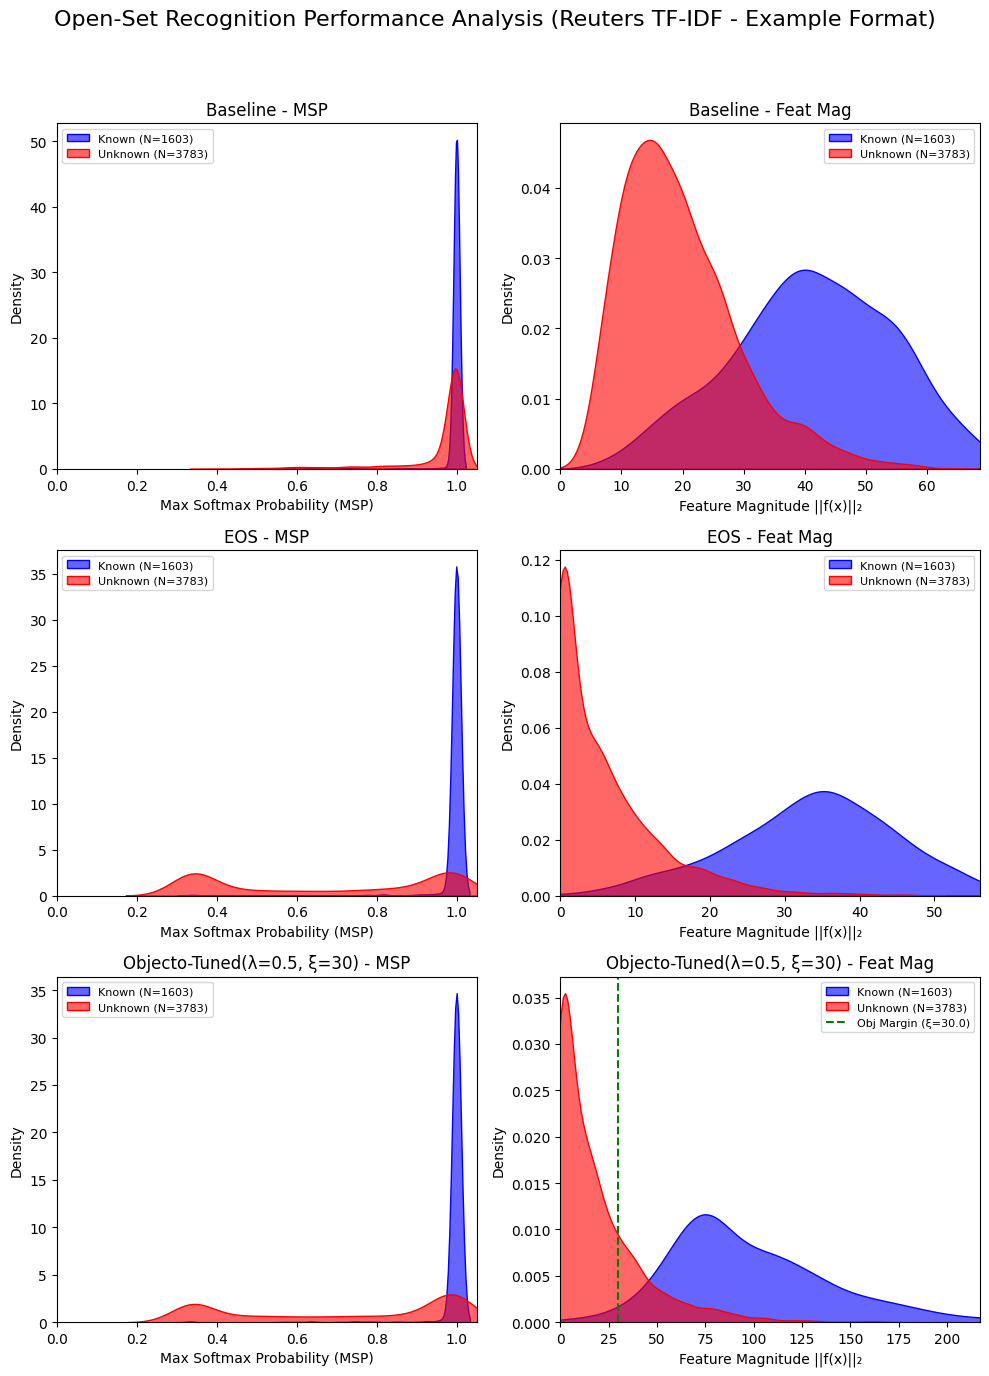


Experiment Complete.


In [120]:
# --- 9. Main Execution ---
if __name__ == "__main__":

    # --- Data Setup ---
    (train_loader, val_loader, test_loader, input_dim, scaler,
     known_categories, unknown_train_categories, unknown_test_categories
     ) = load_and_prepare_reuters_for_example_format(
         NUM_KNOWN_CLASSES, NUM_UNKNOWN_TRAIN_CLASSES, MAX_TFIDF_FEATURES,
         UNKNOWN_LABEL_MAP, SEED
     )

    results_baseline, results_eos, results_obj_orig, results_obj_tuned = None, None, None, None
    tuned_lambda = LAMBDA_OBJ_ORIG # Initialize tuned params to original as fallback
    tuned_xi = XI_OBJ_ORIG

    # --- Baseline Model ---
    try:
        print("\n" + "="*30 + " BASELINE (SOFTMAX) " + "="*30)
        model_baseline = MLP(input_dim, HIDDEN_DIM1, HIDDEN_DIM2, FEATURE_DIM, NUM_KNOWN_CLASSES).to(DEVICE)
        model_baseline.classifier = nn.Linear(FEATURE_DIM, NUM_KNOWN_CLASSES, bias=True).to(DEVICE)
        optimizer_baseline = optim.Adam(model_baseline.parameters(), lr=LEARNING_RATE)
        criterion_baseline = nn.CrossEntropyLoss()
        model_baseline = train_model(model_baseline, train_loader, val_loader, criterion_baseline, optimizer_baseline, EPOCHS, DEVICE, loss_type='baseline', model_label="Baseline", verbose=True, num_known_classes=NUM_KNOWN_CLASSES)
        results_baseline = evaluate_openset(model_baseline, test_loader, DEVICE, NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, model_label="Baseline")
    except Exception as e:
        print(f"ERROR during Baseline model training/evaluation: {e}")

    # --- EOS Model ---
    try:
        print("\n" + "="*30 + " ENTROPIC OPEN-SET (EOS) " + "="*30)
        model_eos = MLP(input_dim, HIDDEN_DIM1, HIDDEN_DIM2, FEATURE_DIM, NUM_KNOWN_CLASSES).to(DEVICE)
        optimizer_eos = optim.Adam(model_eos.parameters(), lr=LEARNING_RATE)
        criterion_eos = EntropicOpenSetLoss(NUM_KNOWN_CLASSES)
        model_eos = train_model(model_eos, train_loader, val_loader, criterion_eos, optimizer_eos, EPOCHS, DEVICE, loss_type='eos', model_label="EOS", verbose=True, num_known_classes=NUM_KNOWN_CLASSES)
        results_eos = evaluate_openset(model_eos, test_loader, DEVICE, NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, model_label="EOS")
    except Exception as e:
        print(f"ERROR during EOS model training/evaluation: {e}")

    # --- Original Objectosphere Model ---
    try:
        print("\n" + "="*30 + " OBJECTOSPHERE (ORIGINAL PARAMS) " + "="*30)
        model_obj_orig = MLP(input_dim, HIDDEN_DIM1, HIDDEN_DIM2, FEATURE_DIM, NUM_KNOWN_CLASSES).to(DEVICE)
        optimizer_obj_orig = optim.Adam(model_obj_orig.parameters(), lr=LEARNING_RATE)
        criterion_obj_orig = ObjectosphereLoss(NUM_KNOWN_CLASSES, LAMBDA_OBJ_ORIG, XI_OBJ_ORIG)
        model_obj_orig = train_model(model_obj_orig, train_loader, val_loader, criterion_obj_orig, optimizer_obj_orig, EPOCHS, DEVICE, loss_type='objectosphere', model_label="Objectosphere-Orig", verbose=True, num_known_classes=NUM_KNOWN_CLASSES)
        results_obj_orig = evaluate_openset(model_obj_orig, test_loader, DEVICE, NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, model_label="Objectosphere-Orig")
    except Exception as e:
        print(f"ERROR during Objectosphere Original model training/evaluation: {e}")

    # --- Hyperparameter Tuning for Objectosphere ---
    try:
        best_obj_params = tune_objectosphere_hyperparameters(
            PARAM_GRID, input_dim, train_loader, val_loader, DEVICE,
            NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, EPOCHS_TUNE
        )
        tuned_lambda = best_obj_params['lambda_obj']
        tuned_xi = best_obj_params['xi_obj']
    except Exception as e:
        print(f"ERROR during Hyperparameter Tuning: {e}")
        print("Using original Objectosphere parameters for tuned model.")
        # Keep initialized values: tuned_lambda = LAMBDA_OBJ_ORIG, tuned_xi = XI_OBJ_ORIG

    # --- Data-Tuned Objectosphere Model ---
    try:
        print("\n" + "="*30 + " OBJECTOSPHERE (DATA-TUNED PARAMS) " + "="*30)
        model_obj_tuned = MLP(input_dim, HIDDEN_DIM1, HIDDEN_DIM2, FEATURE_DIM, NUM_KNOWN_CLASSES).to(DEVICE)
        optimizer_obj_tuned = optim.Adam(model_obj_tuned.parameters(), lr=LEARNING_RATE)
        criterion_obj_tuned = ObjectosphereLoss(NUM_KNOWN_CLASSES, tuned_lambda, tuned_xi)
        model_obj_tuned = train_model(model_obj_tuned, train_loader, val_loader, criterion_obj_tuned, optimizer_obj_tuned, EPOCHS, DEVICE, loss_type='objectosphere', model_label="Objectosphere-Tuned", verbose=True, num_known_classes=NUM_KNOWN_CLASSES)
        results_obj_tuned = evaluate_openset(model_obj_tuned, test_loader, DEVICE, NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, model_label="Objectosphere-Tuned")
    except Exception as e:
        print(f"ERROR during Objectosphere Tuned model training/evaluation: {e}")


    # --- Print Final Summary Table ---
    print("\n" + "="*30 + " FINAL PERFORMANCE SUMMARY " + "="*30)
    print(f"{'Model':<20} | {'Known Acc':<10} | {'AUROC':<10} | {'F1 Unknown':<10}")
    print("-" * 60) # Adjusted length
    models_for_summary = { # Use dict for cleaner access
        "Baseline": results_baseline,
        "EOS": results_eos,
        "Objecto-Orig": results_obj_orig,
        "Objecto-Tuned": results_obj_tuned
    }
    for name, res in models_for_summary.items():
         if res: # Check if result exists
             acc = res.get('known_accuracy', 0.0)
             auroc = res.get('auroc', 0.5)
             f1_unk = res.get('f1_unknown', 0.0)
             print(f"{name:<20} | {acc:.4f}     | {auroc:.4f}   | {f1_unk:.4f}")
         else:
              print(f"{name:<20} | {'N/A':<10} | {'N/A':<10} | {'N/A':<10}") # Align N/A
    print("="*60)

    # --- Evaluate Experiment Success ---
    # Ensure test_loader exists before attempting success evaluation
    if test_loader:
        try:
            success_summary = evaluate_experiment_success(
                results_baseline, results_eos, results_obj_orig, results_obj_tuned
            )
            print("\n" + "="*30 + " EXPERIMENT SUCCESS SUMMARY " + "="*30)
            print(success_summary)
            print("="*80)
        except Exception as e:
            print(f"ERROR during Experiment Success Evaluation: {e}")
    else:
        print("\nSkipping experiment success evaluation as test data was not available or evaluation failed.")


    # --- Generate Plots ---
    if test_loader: # Only plot if evaluation was possible and test loader exists
        print("\n--- Generating Final Plots ---")
        plt.close('all') # Close any existing plots
        fig, axes = plt.subplots(3, 2, figsize=(10, 14)) # 4 rows for models, 3 cols for plots
        fig.suptitle('Open-Set Recognition Performance Analysis (Reuters TF-IDF - Example Format)', fontsize=16, y=1.01)

        all_results = [results_baseline, results_eos, results_obj_orig, results_obj_tuned]
        #model_names = ['Baseline', 'EOS', f'Objecto-Orig(λ={LAMBDA_OBJ_ORIG}, ξ={XI_OBJ_ORIG})', f'Objecto-Tuned(λ={tuned_lambda}, ξ={tuned_xi})']
        model_names = ['Baseline', 'EOS', f'Objecto-Tuned(λ={tuned_lambda}, ξ={tuned_xi})']
        #xi_values = [None, None, XI_OBJ_ORIG, tuned_xi] # Pass Xi for Objecto plots
        xi_values = [None, None, tuned_xi] # Pass Xi for Objecto plots



        for i, (results, model_name, xi_val) in enumerate(zip(all_results, model_names, xi_values)):
             # Safely attempt to get data for plotting
             current_features = results.get('features', None) if results else None
             current_labels = results.get('labels', None) if results else None
             current_msp = results.get('msp', None) if results else None

             # Plot PCA
            #  if current_features is not None and current_labels is not None:
            #      #plot_pca_features(current_features, current_labels, NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, model_name, axes[i, 0])
            #      plot_umap_features(current_features, current_labels, NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, model_name, axes[i, 0])
            #  else: axes[i, 0].set_title(f'{model_name} - PCA (No Data)'); print(f"No feature/label data for {model_name} PCA.")

             # Plot MSP Histogram
             if current_msp is not None and current_labels is not None:
                 plot_msp_histogram(current_msp, current_labels, NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, model_name, axes[i, 0])
             else: axes[i, 1].set_title(f'{model_name} - MSP (No Data)'); print(f"No msp/label data for {model_name} MSP Hist.")

             # Plot Feature Magnitude Histogram
             if current_features is not None and current_labels is not None:
                 plot_feature_magnitude_histogram(current_features, current_labels, NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, model_name, axes[i, 1], xi_obj=xi_val)
             else: axes[i, 2].set_title(f'{model_name} - Feat Mag (No Data)'); print(f"No feature/label data for {model_name} Mag Hist.")


        plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout
        print("\nDisplaying plots...")
        plt.show()
    else:
        print("\nSkipping plot generation as test data was not available or evaluation failed.")


    print("\nExperiment Complete.")

### Saving Plots


--- Generating Final Plots ---
Generating MSP KDE Plot: Baseline


<ipython-input-117-8205f676e245>:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(msp_known, color='blue', label=f'Known (N={len(msp_known)})', shade=True, alpha=0.6, ax=ax)
<ipython-input-117-8205f676e245>:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(msp_unknown, color='red', label=f'Unknown (N={len(msp_unknown)})', shade=True, alpha=0.6, ax=ax)


Saved MSP histogram for Baseline at: final_plots/Baseline_msp_histogram.png
Generating Feature Magnitude KDE Plot: Baseline
Generating Feature Magnitude KDE Plot: Baseline


<ipython-input-117-8205f676e245>:46: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mags_known, color='blue', label=f'Known (N={len(mags_known)})', shade=True, alpha=0.6, ax=ax)
<ipython-input-117-8205f676e245>:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mags_unknown, color='red', label=f'Unknown (N={len(mags_unknown)})', shade=True, alpha=0.6, ax=ax)
<ipython-input-117-8205f676e245>:46: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mags_known, color='blue', label=f'Known (N={len(mags_known)})', shade=True, alpha=0.6, ax=ax)
<ipython-input-117-8205f676e245>:48: FutureWarning: 

`shade` is now deprecated in favor of 

Saved Feature Magnitude histogram for Baseline at: final_plots/Baseline_feature_magnitude_histogram.png
Generating MSP KDE Plot: EOS


<ipython-input-117-8205f676e245>:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(msp_known, color='blue', label=f'Known (N={len(msp_known)})', shade=True, alpha=0.6, ax=ax)
<ipython-input-117-8205f676e245>:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(msp_unknown, color='red', label=f'Unknown (N={len(msp_unknown)})', shade=True, alpha=0.6, ax=ax)


Saved MSP histogram for EOS at: final_plots/EOS_msp_histogram.png
Generating Feature Magnitude KDE Plot: EOS
Generating Feature Magnitude KDE Plot: EOS


<ipython-input-117-8205f676e245>:46: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mags_known, color='blue', label=f'Known (N={len(mags_known)})', shade=True, alpha=0.6, ax=ax)
<ipython-input-117-8205f676e245>:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mags_unknown, color='red', label=f'Unknown (N={len(mags_unknown)})', shade=True, alpha=0.6, ax=ax)
<ipython-input-117-8205f676e245>:46: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mags_known, color='blue', label=f'Known (N={len(mags_known)})', shade=True, alpha=0.6, ax=ax)
<ipython-input-117-8205f676e245>:48: FutureWarning: 

`shade` is now deprecated in favor of 

Saved Feature Magnitude histogram for EOS at: final_plots/EOS_feature_magnitude_histogram.png
Generating MSP KDE Plot: Objecto-Tuned(λ=0.5, ξ=30)


<ipython-input-117-8205f676e245>:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(msp_known, color='blue', label=f'Known (N={len(msp_known)})', shade=True, alpha=0.6, ax=ax)
<ipython-input-117-8205f676e245>:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(msp_unknown, color='red', label=f'Unknown (N={len(msp_unknown)})', shade=True, alpha=0.6, ax=ax)


Saved MSP histogram for Objecto-Tuned(λ=0.5, ξ=30) at: final_plots/Objecto-Tunedlambda0.5_xi30_msp_histogram.png
Generating Feature Magnitude KDE Plot: Objecto-Tuned(λ=0.5, ξ=30)
Generating Feature Magnitude KDE Plot: Objecto-Tuned(λ=0.5, ξ=30)


<ipython-input-117-8205f676e245>:46: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mags_known, color='blue', label=f'Known (N={len(mags_known)})', shade=True, alpha=0.6, ax=ax)
<ipython-input-117-8205f676e245>:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mags_unknown, color='red', label=f'Unknown (N={len(mags_unknown)})', shade=True, alpha=0.6, ax=ax)
<ipython-input-117-8205f676e245>:46: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mags_known, color='blue', label=f'Known (N={len(mags_known)})', shade=True, alpha=0.6, ax=ax)
<ipython-input-117-8205f676e245>:48: FutureWarning: 

`shade` is now deprecated in favor of 

Saved Feature Magnitude histogram for Objecto-Tuned(λ=0.5, ξ=30) at: final_plots/Objecto-Tunedlambda0.5_xi30_feature_magnitude_histogram.png

Saved combined plot at: final_plots/combined_analysis.png

Displaying plots...


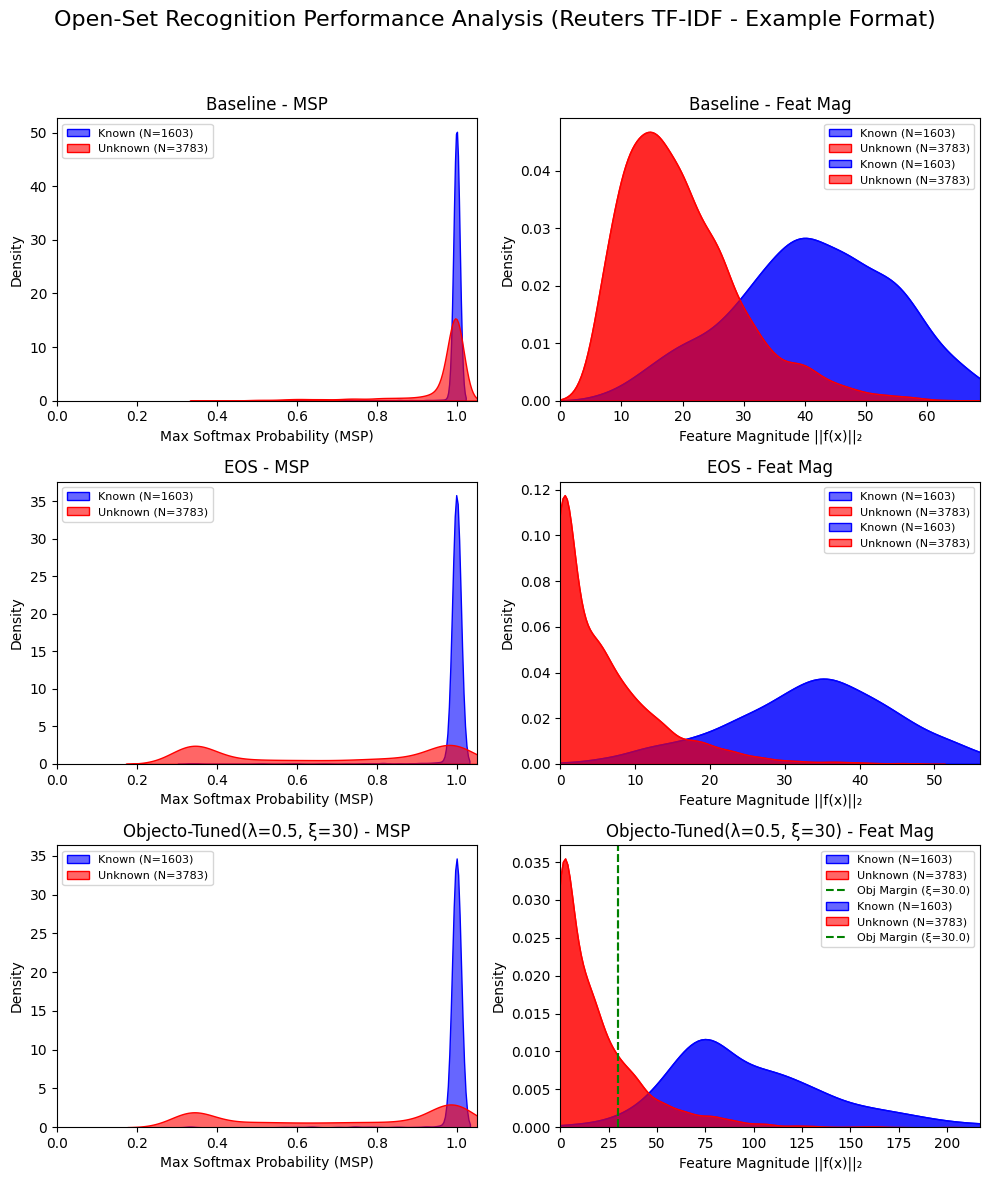

In [121]:
import os

print("\n--- Generating Final Plots ---")
plt.close('all')  # Close any existing plots
fig, axes = plt.subplots(3, 2, figsize=(10, 12))  # 4 rows for models, 2 cols for plots
fig.suptitle('Open-Set Recognition Performance Analysis (Reuters TF-IDF - Example Format)', fontsize=16, y=1.01)

# Create a directory to save plots
output_dir = "final_plots"
os.makedirs(output_dir, exist_ok=True)

all_results = [results_baseline, results_eos, results_obj_orig, results_obj_tuned]
model_names = ['Baseline', 'EOS', f'Objecto-Tuned(λ={tuned_lambda}, ξ={tuned_xi})']
xi_values = [None, None,  tuned_xi]  # Pass Xi for Objecto plots

for i, (results, model_name, xi_val) in enumerate(zip(all_results, model_names, xi_values)):
    current_features = results.get('features', None) if results else None
    current_labels = results.get('labels', None) if results else None
    current_msp = results.get('msp', None) if results else None

    # Format a short filename-safe version of the model name
    model_tag = model_name.replace('(', '').replace(')', '').replace('λ', 'lambda').replace('ξ', 'xi').replace('=', '').replace(',', '').replace(' ', '_')

    # Plot MSP Histogram
    if current_msp is not None and current_labels is not None:
        plot_msp_histogram(current_msp, current_labels, NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, model_name, axes[i, 0])
        msp_path = os.path.join(output_dir, f"{model_tag}_msp_histogram.png")
        axes[i, 0].figure.savefig(msp_path)
        print(f"Saved MSP histogram for {model_name} at: {msp_path}")
    else:
        axes[i, 0].set_title(f'{model_name} - MSP (No Data)')
        print(f"No msp/label data for {model_name} MSP Hist.")

    # Plot Feature Magnitude Histogram
    if current_features is not None and current_labels is not None:
        plot_feature_magnitude_histogram(current_features, current_labels, NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP, model_name, axes[i, 1], xi_obj=xi_val)
        plot_feature_magnitude_histogram(current_features, current_labels,NUM_KNOWN_CLASSES, UNKNOWN_LABEL_MAP,model_name, axes[i, 1],xi_obj=xi_val)

        mag_path = os.path.join(output_dir, f"{model_tag}_feature_magnitude_histogram.png")
        axes[i, 1].figure.savefig(mag_path)
        print(f"Saved Feature Magnitude histogram for {model_name} at: {mag_path}")
    else:
        axes[i, 1].set_title(f'{model_name} - Feat Mag (No Data)')
        print(f"No feature/label data for {model_name} Mag Hist.")

plt.tight_layout(rect=[0, 0.03, 1, 0.98])  # Adjust layout
full_fig_path = os.path.join(output_dir, "combined_analysis.png")
plt.savefig(full_fig_path)
print(f"\nSaved combined plot at: {full_fig_path}")
print("\nDisplaying plots...")
plt.show()

